In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(),transforms.ToTensor()
])

In [9]:
train_set = datasets.CIFAR10(
    root="./data/CIFAR10",
    train = True,
    transform=transform,
    download=True
)

test_set = datasets.CIFAR10(
    root="./data/CIFAR10",
    train = False,
    transform = transform,
    download = True
)

train_size = int(len(train_set)*0.9)
val_size = len(train_set)-train_size
train_set,val_set = torch.utils.data.random_split(train_set,[train_size,val_size])

batch_size=128

train_loader = DataLoader(train_set,batch_size,True)
val_loader = DataLoader(val_set,batch_size,True)
test_loader = DataLoader(test_set,batch_size,True)

In [10]:
train_set[0]

(tensor([[[0.2275, 0.2510, 0.2824,  ..., 0.2627, 0.2392, 0.1922],
          [0.4353, 0.4039, 0.3490,  ..., 0.2902, 0.2471, 0.2078],
          [0.3020, 0.2392, 0.1843,  ..., 0.3451, 0.3333, 0.2902],
          ...,
          [0.0588, 0.0431, 0.0431,  ..., 0.3373, 0.2706, 0.2588],
          [0.0431, 0.0588, 0.0431,  ..., 0.3451, 0.2706, 0.2235],
          [0.1255, 0.1137, 0.0863,  ..., 0.2510, 0.2118, 0.2392]]]),
 6)

In [11]:
class simple_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.maxp = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(128,128,kernel_size=3,padding=1,stride=2)
        self.conv6 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv7 = nn.Conv2d(128,256,kernel_size=3,padding=1,stride=2)
        self.fc1 = nn.Linear(256,128)
        self.fc2 = nn.Linear(128,10)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(0.5)
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxp(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [12]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    val_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return val_loss,accuracy

In [13]:
def train_one_epoch(model,optimizer,criterion,loader,device):
    model.train()
    running_loss = 0.0

    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs=model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss       

In [14]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = simple_cnn().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 1e-3,
)

Using device: cuda
simple_cnn(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-

In [15]:
num_epochs = 15

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,loader=train_loader,
        optimizer=optimizer,criterion=criterion,
        device=device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/15] Train Loss: 1.4102 Val Loss: 1.1162 Val Acc: 0.5914
Epoch [2/15] Train Loss: 0.9716 Val Loss: 1.3215 Val Acc: 0.5486
Epoch [3/15] Train Loss: 0.7958 Val Loss: 1.1140 Val Acc: 0.6158
Epoch [4/15] Train Loss: 0.6719 Val Loss: 0.7268 Val Acc: 0.7548
Epoch [5/15] Train Loss: 0.5721 Val Loss: 0.7722 Val Acc: 0.7358
Epoch [6/15] Train Loss: 0.5012 Val Loss: 0.7034 Val Acc: 0.7738
Epoch [7/15] Train Loss: 0.4318 Val Loss: 0.7070 Val Acc: 0.7588
Epoch [8/15] Train Loss: 0.3666 Val Loss: 0.8391 Val Acc: 0.7634
Epoch [9/15] Train Loss: 0.3142 Val Loss: 0.8942 Val Acc: 0.7372
Epoch [10/15] Train Loss: 0.2583 Val Loss: 0.8338 Val Acc: 0.7564
Epoch [11/15] Train Loss: 0.2153 Val Loss: 0.8498 Val Acc: 0.7724
Epoch [12/15] Train Loss: 0.1776 Val Loss: 0.7480 Val Acc: 0.7956
Epoch [13/15] Train Loss: 0.1532 Val Loss: 0.7344 Val Acc: 0.8088
Epoch [14/15] Train Loss: 0.1287 Val Loss: 0.9009 Val Acc: 0.7902
Epoch [15/15] Train Loss: 0.1132 Val Loss: 0.8689 Val Acc: 0.7954


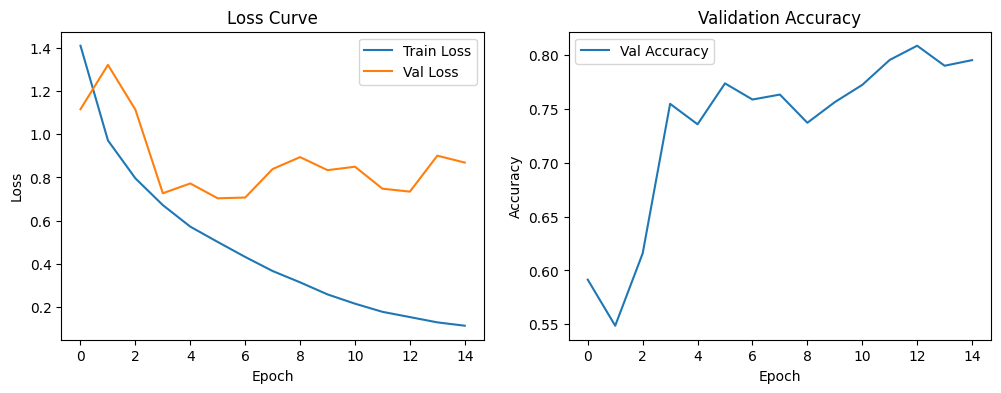

In [16]:
def plot_curves(train_losses,val_losses,val_accuracies):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")

    plt.show()

plot_curves(train_losses,val_losses,val_accuracies)

In [17]:
class cnn_activ(simple_cnn):
    def forward(self,x):
        activations = {}
        activations["og"]=x
        x = F.relu(self.bn1(self.conv1(x)))
        activations["conv1"] = x
        x = F.relu(self.bn2(self.conv2(x)))
        activations["conv2"] = x
        x = F.relu(self.bn3(self.conv3(x)))
        activations["conv3"] = x
        x = self.maxp(x)
        activations["max"] = x
        x = F.relu(self.bn4(self.conv4(x)))
        activations["conv4"] = x
        x = F.relu(self.bn5(self.conv5(x)))
        activations["conv5"] = x
        x = F.relu(self.bn6(self.conv6(x)))
        activations["conv6"] = x
        x = F.relu(self.bn7(self.conv7(x)))
        activations["conv7"] = x
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x,activations

In [19]:
import math
def visualize_feature_maps(model, image, device="mps", num_maps=16):
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Assuming your model returns (output, activations_dict)
    _, activations = model(image)

    for name, act in activations.items():
        act = act.cpu().detach()
        # Determine actual number of maps to show
        total_maps = min(num_maps, act.shape[1])
    # Calculate grid dimensions (e.g., 4x4 for 16 maps)
    cols = int(math.sqrt(total_maps))
    rows = math.ceil(total_maps / cols)

    # Increase figsize for better detail (e.g., 15x15 or larger)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(f"Layer: {name}", fontsize=16)
    # Flatten axes if there's more than one row/column
    axes = axes.flatten() if total_maps > 1 else [axes]

    for i in range(total_maps):
    # Using 'viridis' or 'magma' often shows detail better than grayscale
        axes[i].imshow(act[0, i], interpolation='nearest')
        axes[i].axis("off")
        axes[i].set_title(f"Map {i}", fontsize=10)

    # Hide any unused subplots in the grid
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

In [22]:

import math

def visualize_feature_maps(model, image, device=None, num_maps=16):
    """
    Visualizes the feature maps of a model.
    Note: This assumes the model's forward pass returns (output, activations_dict).
    """
    # Auto-detect device if not provided
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else \
                 "cuda" if torch.cuda.is_available() else "cpu"
    
    model.to(device)
    model.eval()
    
    # Prepare image (add batch dimension)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        # Assuming your model returns (output, activations_dict)
        _, activations = model(image)

    for name, act in activations.items():
        # Move to CPU and remove from computation graph
        act = act.cpu().detach()
        
        # Determine actual number of maps to show (don't exceed available channels)
        total_maps = min(num_maps, act.shape[1])
        
        # Calculate grid dimensions
        cols = int(math.sqrt(total_maps))
        rows = math.ceil(total_maps / cols)

        # Increase figsize for better detail
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle(f"Layer: {name}", fontsize=16)
        
        # Flatten axes if there's more than one subplot
        if total_maps > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for i in range(total_maps):
            # Using 'viridis' provides better contrast for activation levels
            axes[i].imshow(act[0, i], interpolation='nearest')
            axes[i].axis("off")
            axes[i].set_title(f"Map {i}", fontsize=10)

        # Hide any unused subplots in the grid
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
        plt.show()

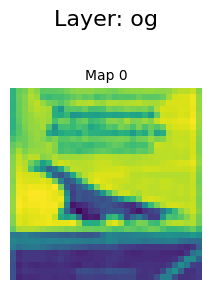

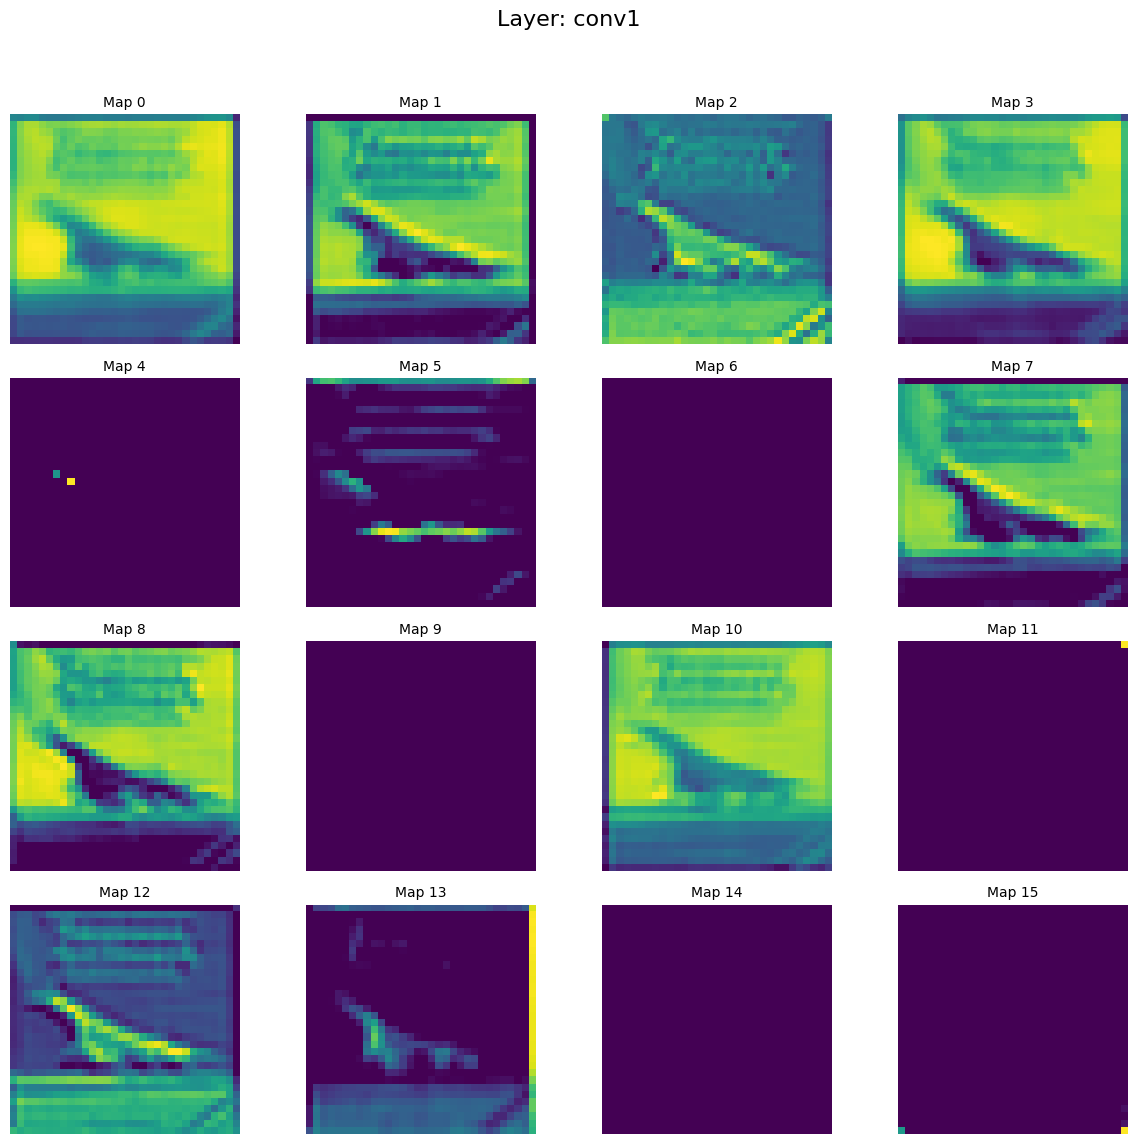

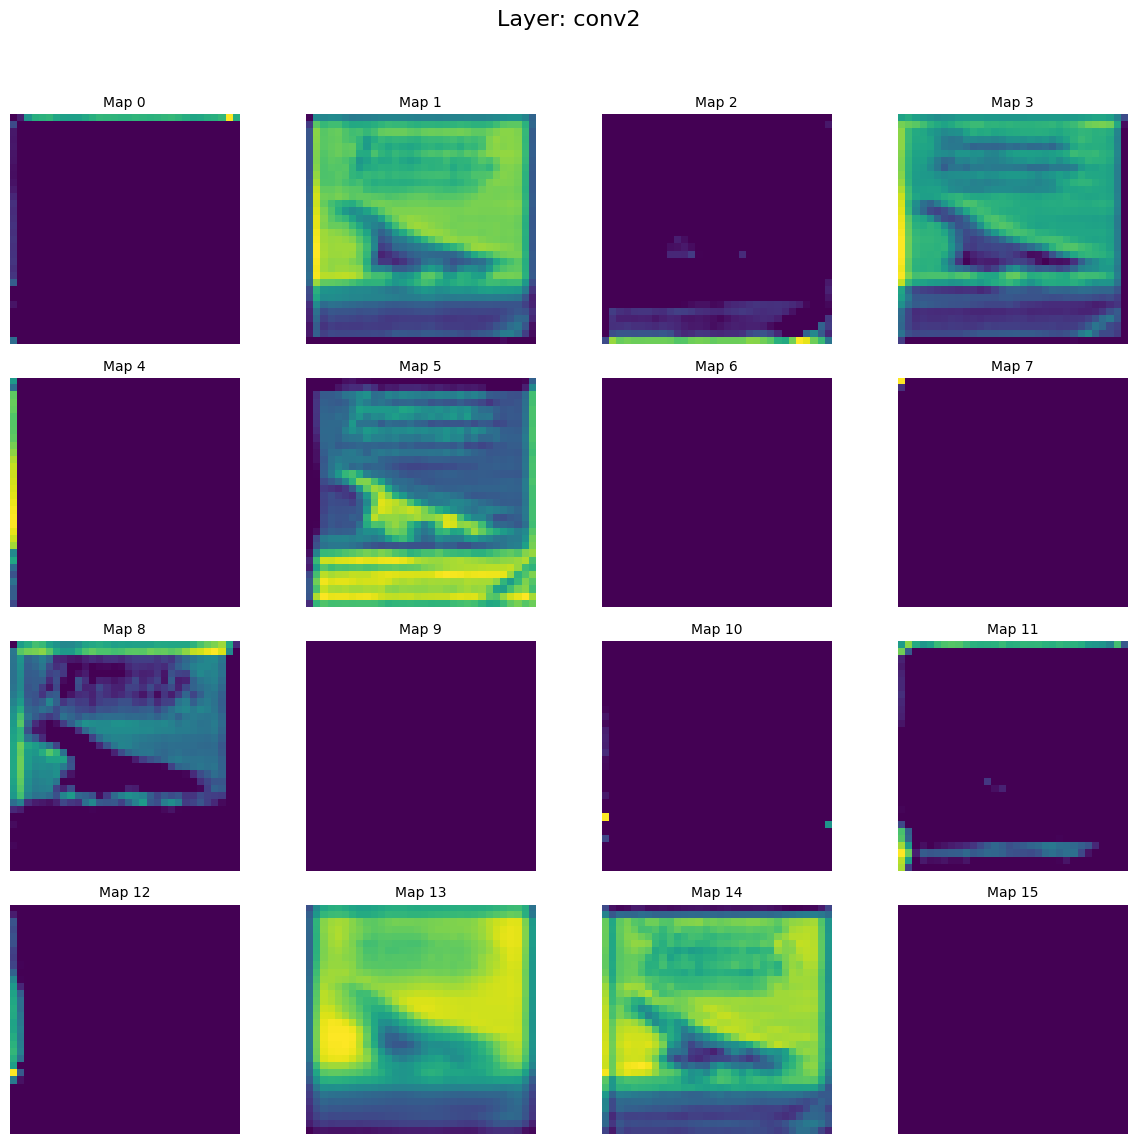

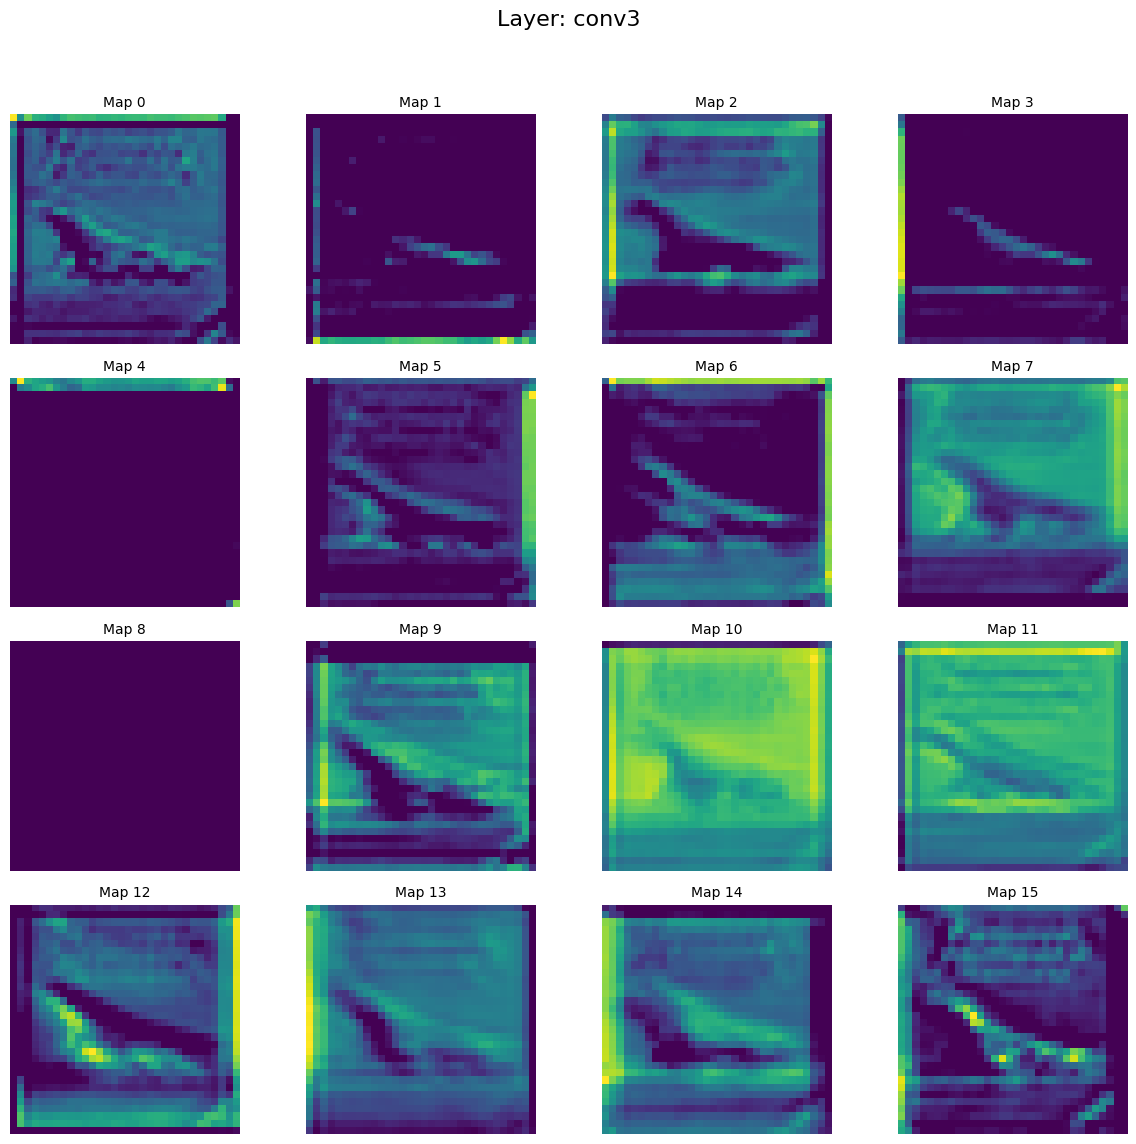

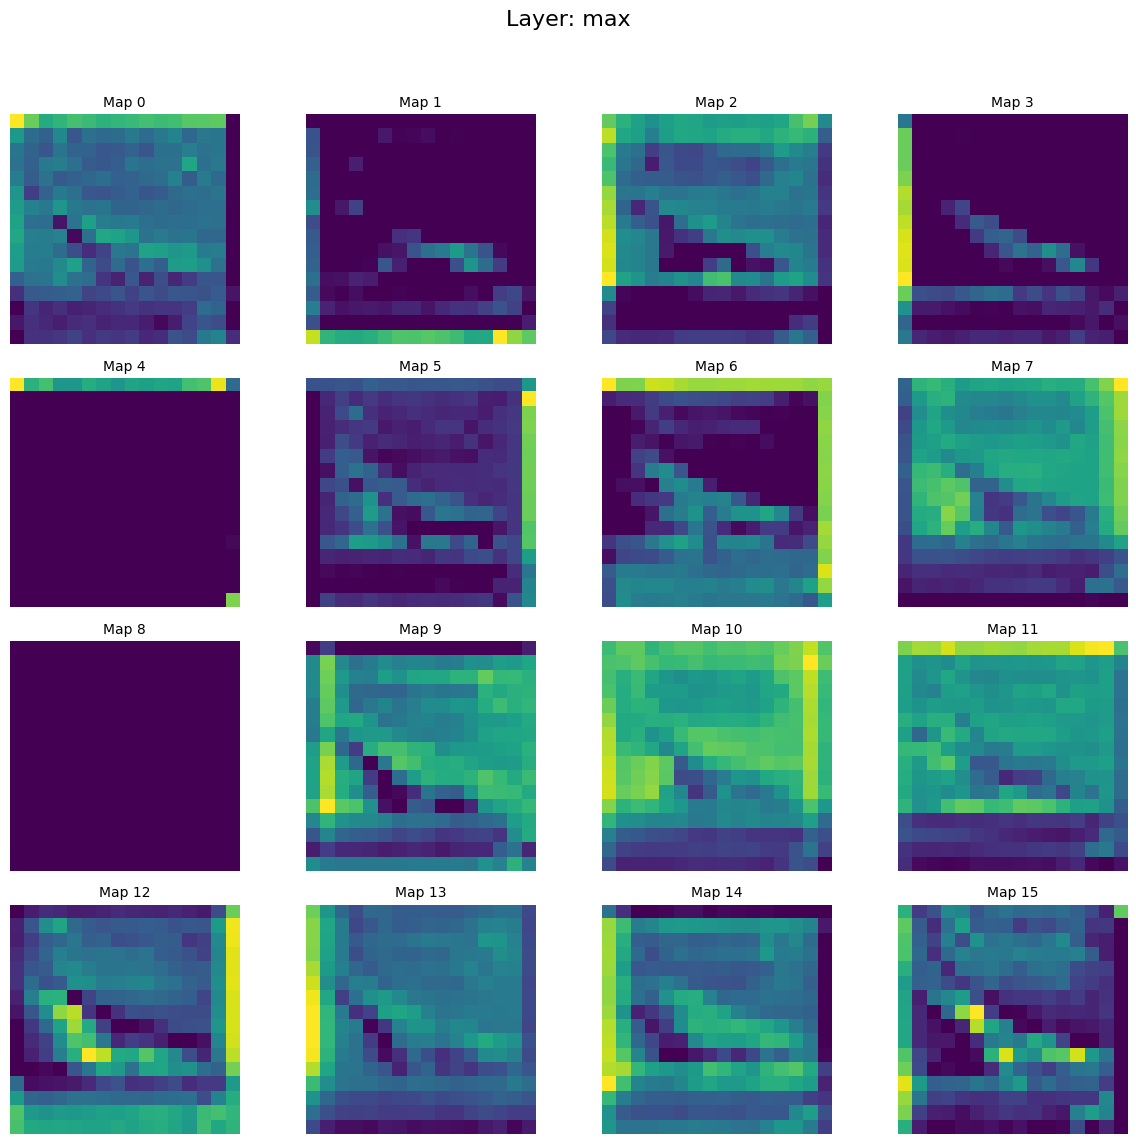

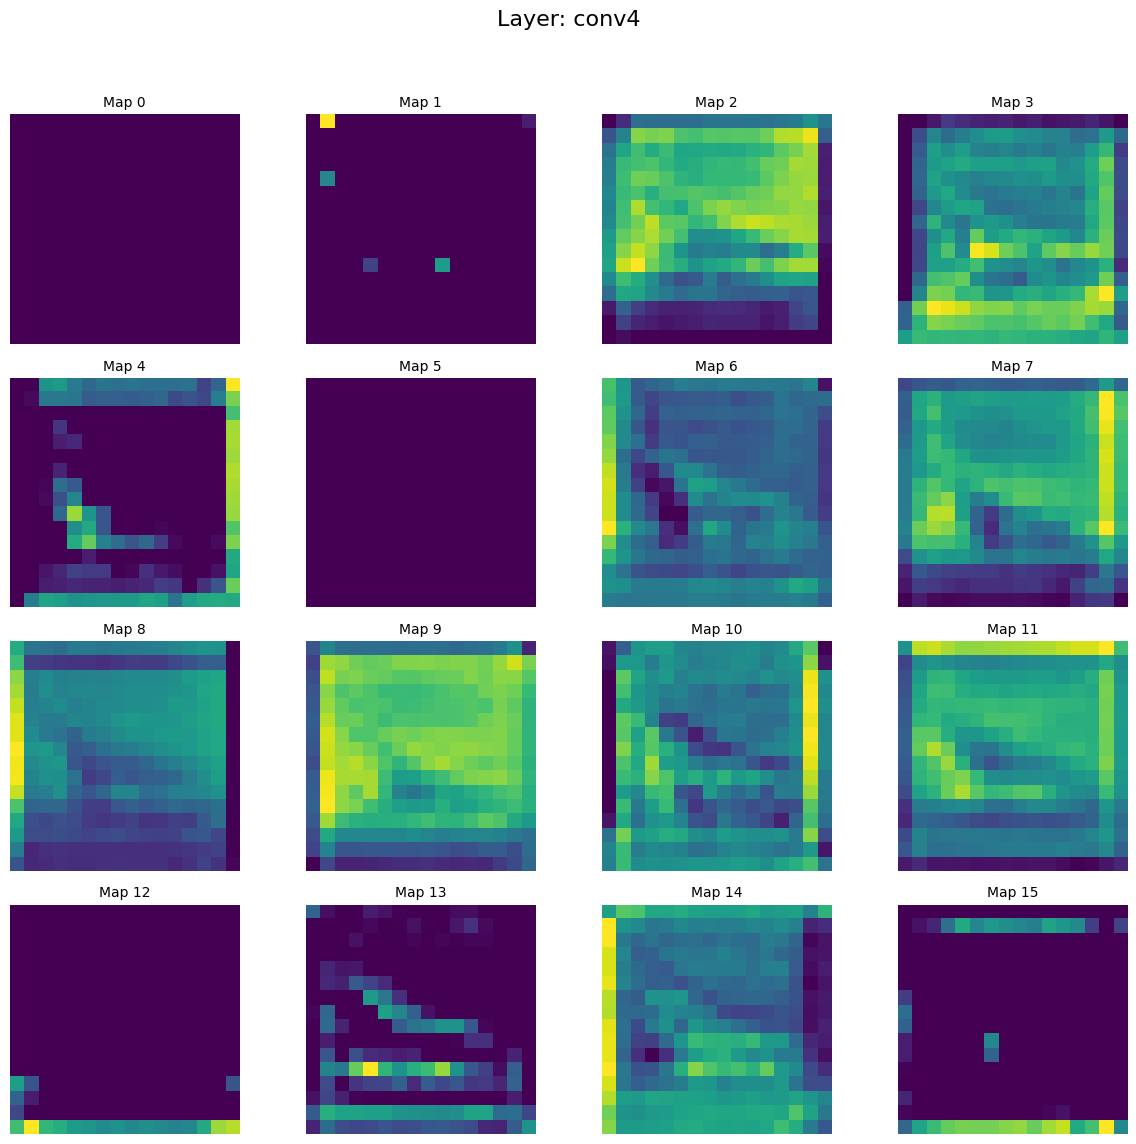

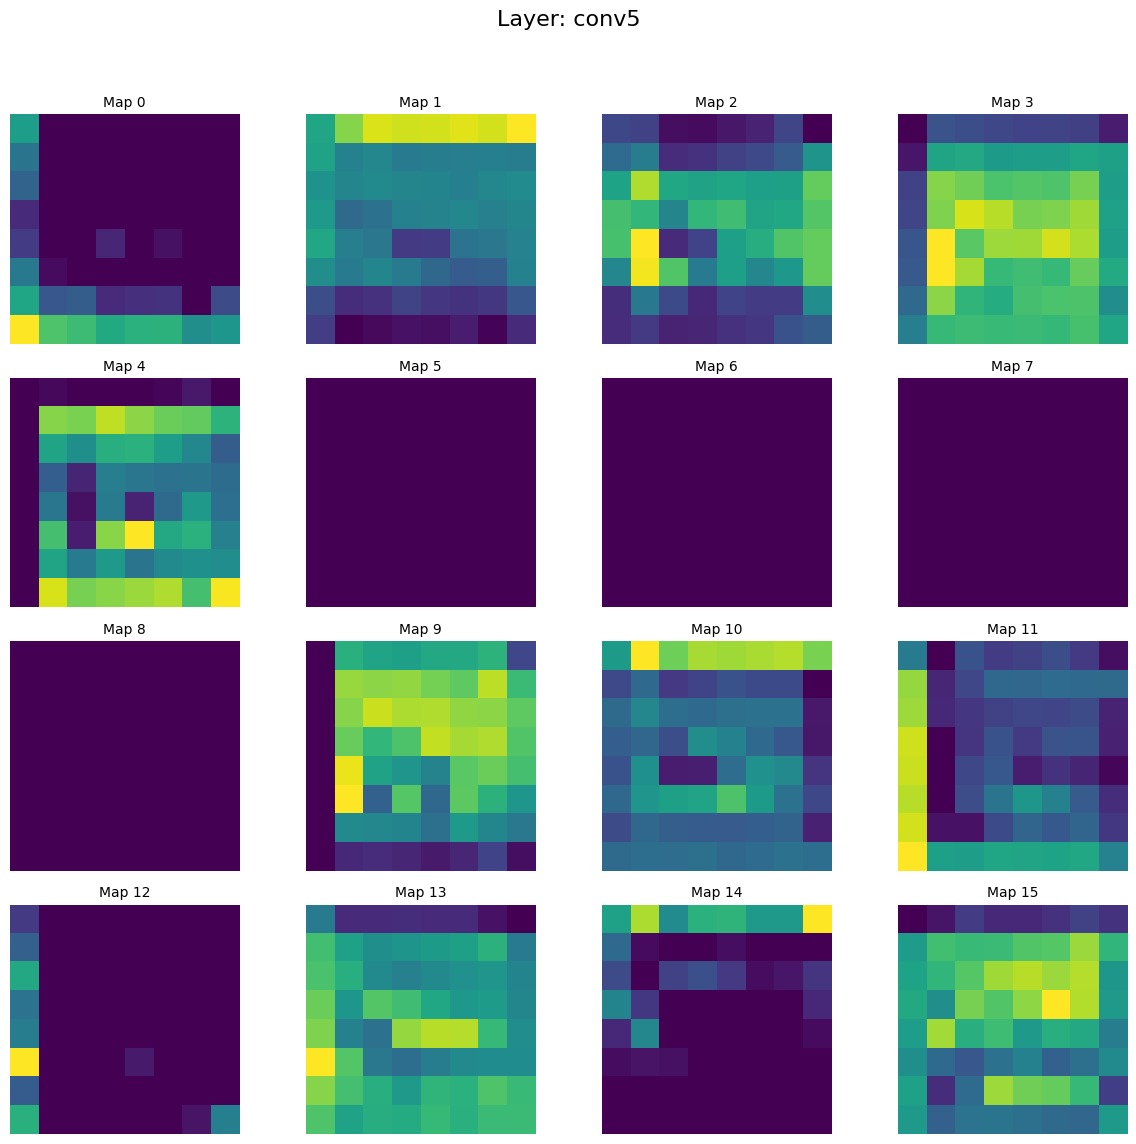

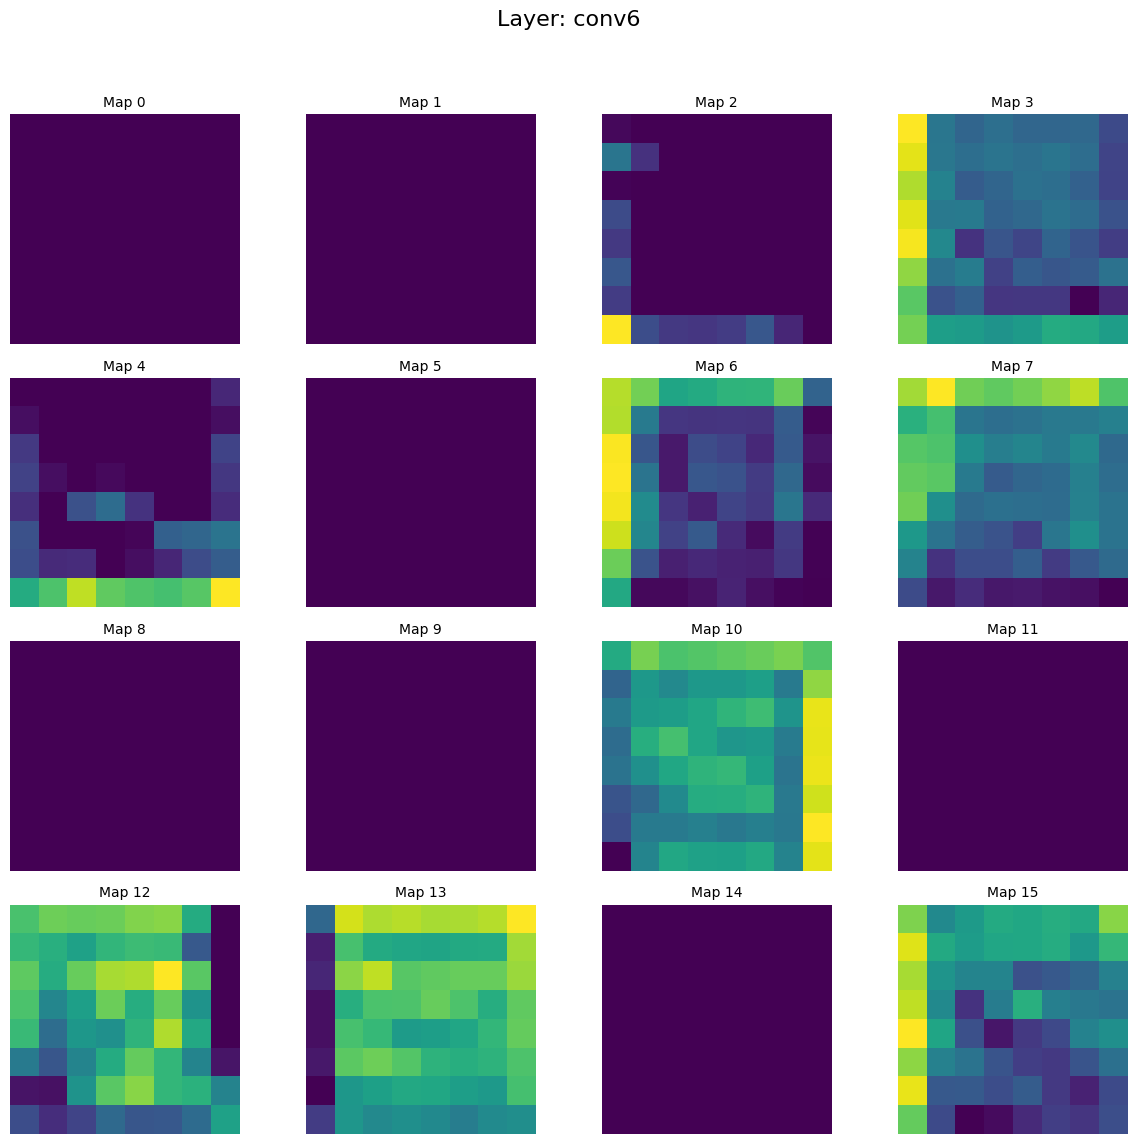

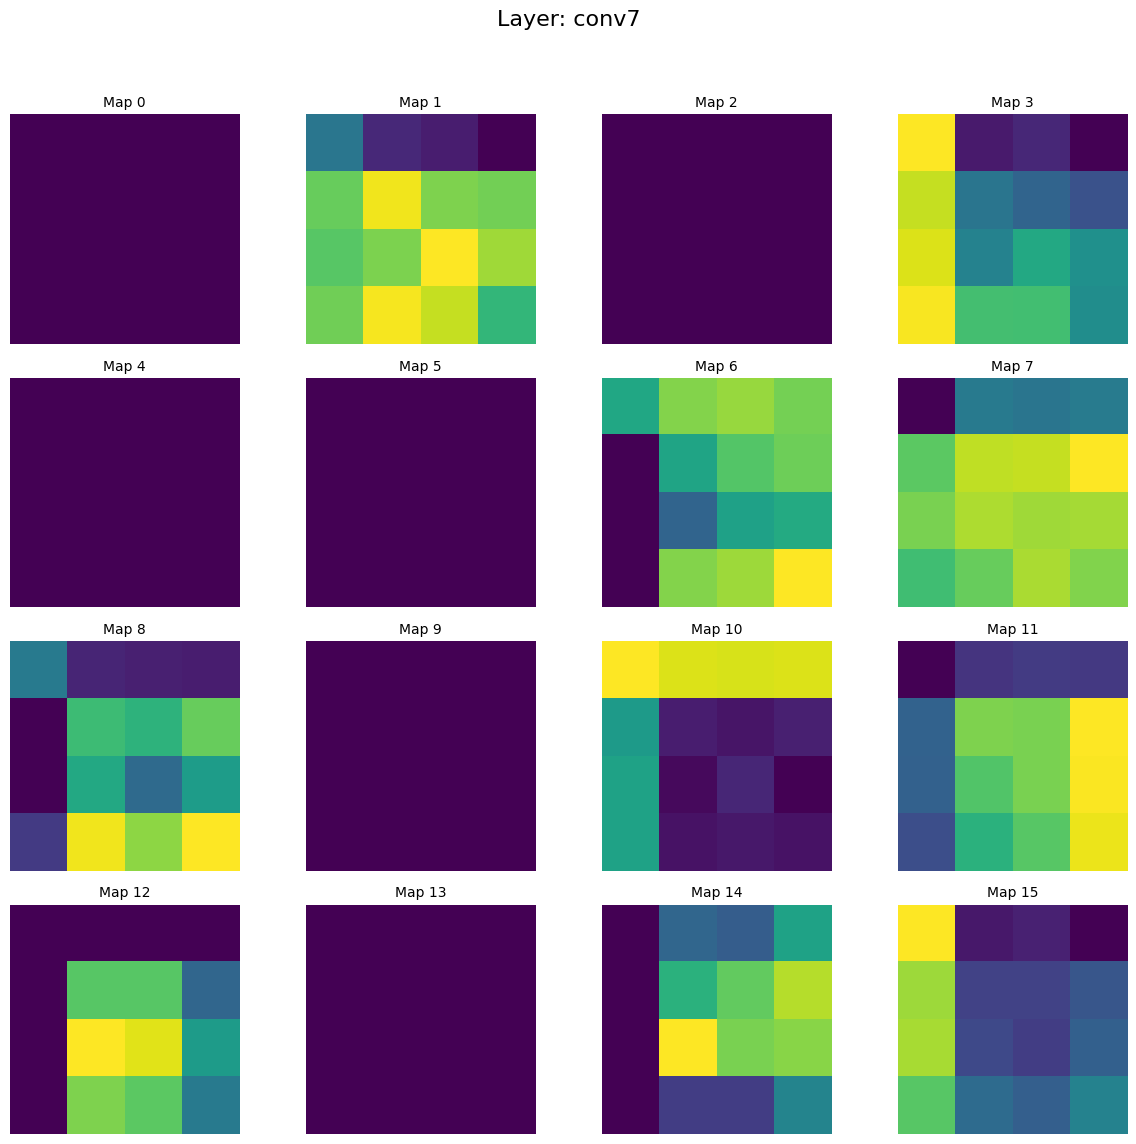

In [23]:
cnn_with_activations = cnn_activ().to(device)

sample_img, label = test_set[3]
visualize_feature_maps(cnn_with_activations,sample_img,device=device)

: 